# Pump it Up: Data Mining the Water Table 

In this competition, we are trying to predict which water pumps are functional in some places in Tanzania. This competition is hosted by [DrivenData](https://www.drivendata.org) and the dataset is provided [Taarifa](http://taarifa.org/) and the [Tanzanian Ministry of Water](http://maji.go.tz/).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Reading the data

In [2]:
train = pd.read_csv("input/train.csv",index_col=0)
test = pd.read_csv("input/test.csv",index_col=0)
train_labels = pd.read_csv("input/train_labels.csv",index_col=0)

In [3]:
#train = pd.merge(train, train_labels, left_on="id", right_on="id")
all_df = pd.concat((train, test), axis=0)

In [4]:
train.shape, test.shape, all_df.shape

((59400, 39), (14850, 39), (74250, 39))

In [5]:
#tNull checking, let's take care of these values
#train.isnull().sum().sort_values(ascending=False).head(8)
#test.isnull().sum().sort_values(ascending=False).head(8)

## Replacing NaN values

In [6]:
all_df.replace(['Not Known'], ['unkown'], inplace=True)
all_df.loc[all_df.scheme_name.isnull(), 'scheme_name'] = 'unknown'
all_df.loc[all_df.scheme_management.isnull(), 'scheme_management'] = 'unknown'
all_df.loc[all_df.funder.isnull(), 'funder'] = 'unknown'
all_df.loc[all_df.installer.isnull(), 'installer'] = 'unknown'
all_df.loc[all_df.subvillage.isnull(), 'subvillage'] = 'unknown'
all_df.loc[all_df.public_meeting.isnull(), 'public_meeting'] = False
all_df.loc[all_df.permit.isnull(), 'permit'] = False


In [7]:
all_df.isnull().sum().sort_values(ascending=False).head(5)

waterpoint_type_group    0
basin                    0
population               0
ward                     0
lga                      0
dtype: int64

## Fixing features

### Deleting unused features

In [8]:
# height, longitude and latitute demand more processing, do it later
exclude_features = ["longitude", "latitude"]
all_df = all_df.drop(exclude_features, 1)
all_df.shape

# these features are duplicated in the dataset (there are other features with exact same values)
duplicated_features = ["payment", "quantity"]
all_df = all_df.drop(duplicated_features, 1)
all_df.shape

# these features are redundant in the data set (there are other features that explain it better)
redundant_features = ["source_type", "waterpoint_type_group"]
all_df = all_df.drop(redundant_features, 1)
all_df.shape

# these features only have 1 value for all rows
unused_features = ["recorded_by"]
all_df = all_df.drop(unused_features, 1)
all_df.shape

(74250, 32)

### Processing dates

For now, we are going to use only year and month in which a pump has been built.

In [9]:
def get_year(date):
    if date != None:
        return date[:4]
    return 0

def get_month(date):
    if date != None:
        return date[5:-3]
    return 0

all_df["year_recorded"] = (all_df["date_recorded"].apply(get_year)).astype('int')
all_df["month_recorded"] = all_df["date_recorded"].apply(get_month).astype('int')

#all_df = all_df.drop("date_recorded", 1)

### Changing string to float

Some float values are read as strings, so let's fix them.

In [10]:
# change from string to float
all_df["amount_tsh"] = pd.to_numeric(all_df.amount_tsh)

# change from int to string
# there's no visible pattern between years and defects, plus unkown construction year is saved as 0
all_df["construction_year"] = all_df["construction_year"].astype('str')

## Changing unique categorical features

A lot of features have many unique values (e.g. there are many funders that only built 1 water pump). We are going to change all values with less than 10 occurrences into one group.

In [11]:
categorical_features = all_df.select_dtypes(include=['object'])

for col in categorical_features:
    val_counts = all_df[col].value_counts()
    vals_to_remove = val_counts[val_counts <= 10].index.values
    all_df[col].loc[all_df[col].isin(vals_to_remove)] = "Many_Unique"

/usr/lib/python2.7/dist-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## One hot encoding (Option 1)

Here we are changing categorical values to numerical ones. Maybe it's interesting to use dummy variables later on.

In [12]:
categorical_features = all_df.select_dtypes(include=['object'])

for col in all_df:
    if col in categorical_features:
        all_df[col] = pd.factorize(all_df[col])[0]

## Generating dummy features (Option 2)

This option generates more than 5000 columns, so we are going to skip it.

In [13]:
#print(all_df.shape)
#all_dummy_df = pd.get_dummies(all_df)


## Separating train and test again

In [14]:
train_df = all_df.loc[train.index]
test_df = all_df.loc[test.index]

train_df.shape, test_df.shape, train_labels.shape

((59400, 34), (14850, 34), (59400, 1))

## Visualization

Let's plot some charts and see how interesting is the data we have

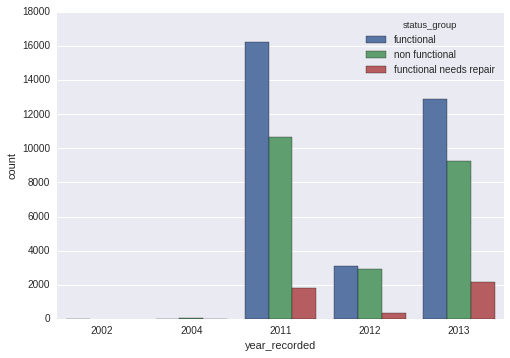

In [15]:
sns.countplot(x=train_df["year_recorded"], hue=train_labels['status_group'])

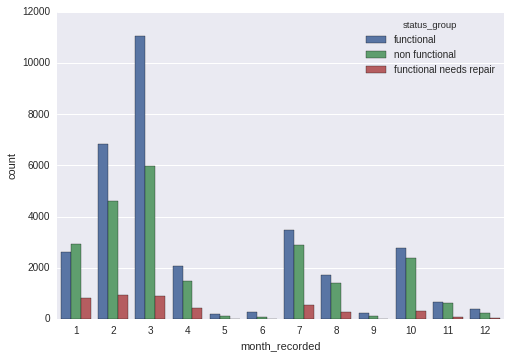

In [16]:
sns.countplot(x=train_df["month_recorded"], hue=train_labels['status_group'])

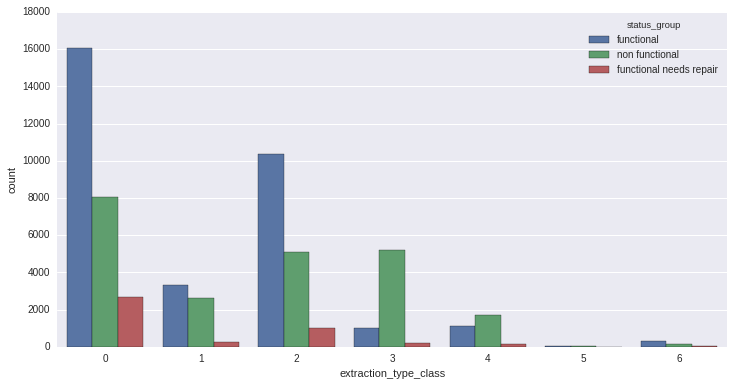

In [17]:
plt.figure(figsize = (12, 6))
sns.countplot(x=train_df["extraction_type_class"], hue=train_labels['status_group'])

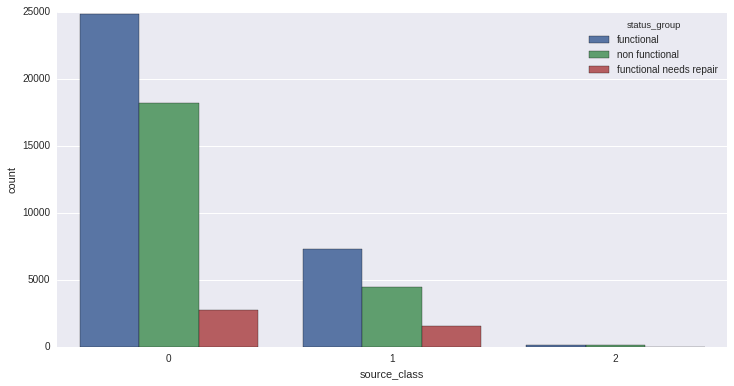

In [18]:
plt.figure(figsize = (12, 6))
sns.countplot(x=train_df["source_class"], hue=train_labels['status_group'])

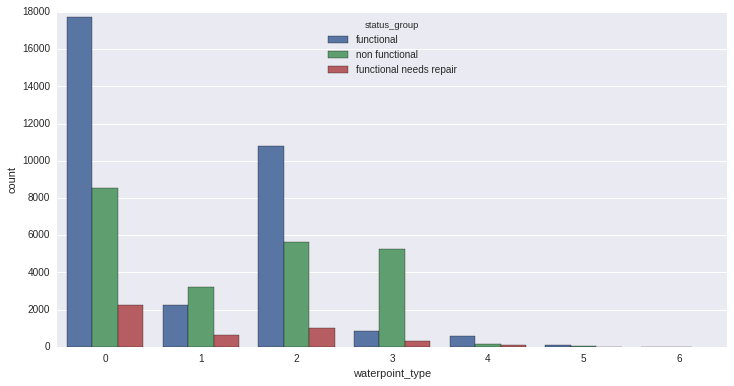

In [34]:
plt.figure(figsize = (12, 6))
sns.countplot(x=train_df["waterpoint_type"], hue=train_labels['status_group'])

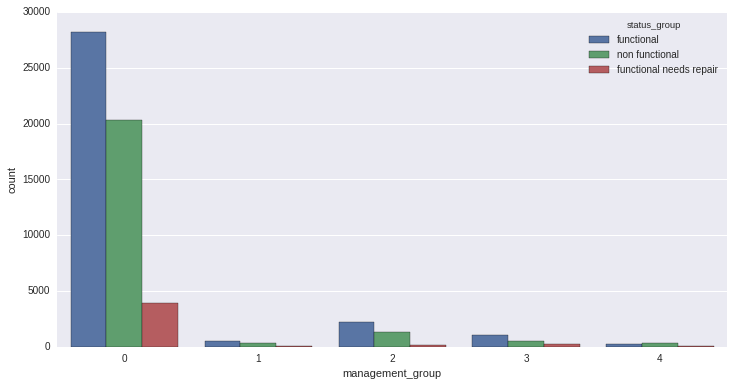

In [33]:
plt.figure(figsize = (12, 6))
sns.countplot(x=train_df["management_group"], hue=train_labels['status_group'])

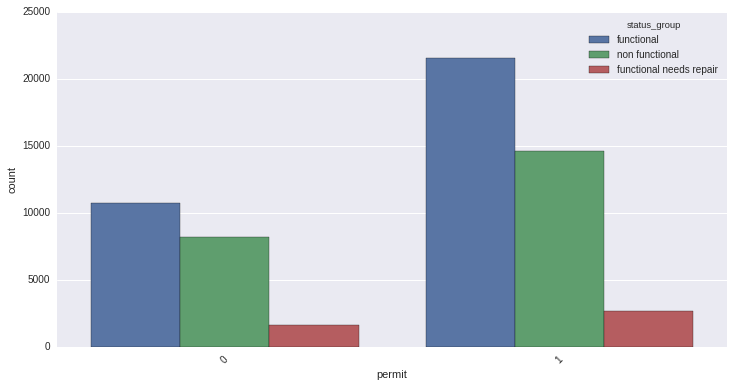

In [22]:
plt.figure(figsize = (12, 6))
sns.countplot(x=train_df["permit"], hue=train_labels['status_group'])
xt = plt.xticks(rotation=45)

## Building the model

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [24]:
#X_train, X_test, y_train, y_test = train_test_split(train_df, train_labels["status_group"], test_size=0.3)
#train_df.shape, X_train.shape, X_test.shape

In [25]:
alg = RandomForestClassifier(random_state=1, n_estimators=100, n_jobs=3)
alg.fit(train_df, train_labels["status_group"])

scores = cross_val_score(alg, train_df, train_labels["status_group"], cv=3, )

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.00)


In [26]:
alg = GradientBoostingClassifier(random_state=1, n_estimators=100)
alg.fit(train_df, train_labels["status_group"])

scores = cross_val_score(alg, train_df, train_labels["status_group"], cv=3)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.75 (+/- 0.00)
